In [97]:
import yaml
import torch
import time
import numpy as np

from models import EdgeGNN, GAT, GCN, GraphSAGE, GIN, MLP, NodeEdgeGNN, SWEGNN
from data import FloodEventDataset
from training import NodeRegressionTrainer, EdgeRegressionTrainer, DualRegressionTrainer

In [98]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [99]:
np.random.seed(42)
torch.manual_seed(42)

In [100]:
with open('configs/config.yaml') as f:
    config = yaml.safe_load(f)

In [ ]:
root = 'data/datasets/lr'
hec_ras_hdf_file = 'M01.p01.hdf'
nodes_shp_file = 'geometry/cell_centers.shp'
edges_shp_file = 'geometry/links.shp'
dataset = FloodEventDataset(root=root,
                    hec_ras_hdf_file=hec_ras_hdf_file,
                    nodes_shp_file=nodes_shp_file,
                    edges_shp_file=edges_shp_file,
                    previous_timesteps=2,
                    node_features=config['node_features'],
                    edge_features=config['edge_features'],
                    debug=True)

Loading data from the following files:
	Graph Metadata Filepath: c:\Users\Carlo\Documents\School\Masters\NUS\gnn_flood_modeling\data\graph_metadata.yaml
	Feature Metadata Filepath: c:\Users\Carlo\Documents\School\Masters\NUS\gnn_flood_modeling\data\feature_metadata.yaml
	HEC-RAS HDF Filename: data\datasets\lr\M01.p01.hdf
	Nodes SHP Filepath: data\datasets\lr\geometry\cell_centers.shp
	Edges SHP Filepath: data\datasets\lr\geometry\links.shp
Timesteps: 577
Timestep delta: 0:30:00


Processing...


Graph properties:
	Edge Index: torch.Size([2, 44012])
	Pos: torch.Size([2, 22551])
Successfully loaded for node_features:
	static (Shape: torch.Size([22551, 3])):
		area: (22551,)
		roughness: (22551,)
		elevation: (22551,)
	dynamic (Shape: torch.Size([577, 22551, 1])):
		water_level: (577, 22551)
Successfully loaded for edge_features:
	static (Shape: torch.Size([44012, 5])):
		direction_x: (44012,)
		direction_y: (44012,)
		face_length: (44012,)
		length: (44012,)
		slope: (44012,)
	dynamic (Shape: torch.Size([577, 44012, 1])):
		velocity: (577, 44012)
Expected node_features format:
	[
		area (static)
		roughness (static)
		elevation (static)
		water_level t-2 (dynamic)
		water_level t-1 (dynamic)
		water_level t (dynamic)
	]
Expected edge_features format:
	[
		direction_x (static)
		direction_y (static)
		face_length (static)
		length (static)
		slope (static)
		velocity t-2 (dynamic)
		velocity t-1 (dynamic)
		velocity t (dynamic)
	]
Saved dataset info to data\datasets\lr\processed\

Done!
c:\Users\Carlo\Documents\School\Masters\NUS\gnn_flood_modeling\data\flood_event_dataset.py:130: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(self.pr

ValueError: too many values to unpack (expected 2)

In [63]:
dataset, info = FloodingEventDataset(node_features=config['node_features'],
                    edge_features=config['edge_features'],
                    debug=True,
                    **config['dataset_parameters']).load()

NameError: name 'FloodingEventDataset' is not defined

In [ ]:
num_train = int(len(dataset) * 0.8) # 80% train, 20% test

train_dataset = dataset[:num_train]
# train_loader = DataLoader(train_dataset) # batch_size=32, shuffle=True

test_dataset = dataset[num_train:]
# test_loader = DataLoader(test_dataset) # batch_size=32, shuffle=True

In [7]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
base_model_params = {
    'static_node_features': info['num_static_node_features'],
    'dynamic_node_features': info['num_dynamic_node_features'],
    'static_edge_features': info['num_static_edge_features'],
    'dynamic_edge_features': info['num_dynamic_edge_features'],
    'previous_timesteps': info['previous_timesteps'],
    'device': device,
}
lr_info = config['training_parameters']

## Node Prediction Models

In [8]:
node_model_map = {
    'SWEGNN': SWEGNN,
    'GCN': GCN,
    'GAT': GAT,
    'GIN': GIN,
    'GraphSAGE': GraphSAGE,
    'MLP': MLP,
}

In [9]:
model_name = 'GCN'
model_params = config['model_parameters'][model_name]
if model_name == 'MLP':
    model_params['num_nodes'] = len(train_dataset[0].x)
model = node_model_map[model_name](**model_params, **base_model_params)

num_epochs = 10
optimizer = torch.optim.Adam(model.parameters(), lr=lr_info['learning_rate'], weight_decay=lr_info['weight_decay'])
loss_func = torch.nn.L1Loss()

trainer = NodeRegressionTrainer(train_dataset=train_dataset, val_dataset=test_dataset, model=model,
                                loss_func=loss_func, optimizer=optimizer, num_epochs=num_epochs, device=device)
trainer.train()
trainer.validate()

Epoch [1/10], Training Loss: 37.1307
Epoch [2/10], Training Loss: 16.3665
Epoch [3/10], Training Loss: 14.5061
Epoch [4/10], Training Loss: 14.7616
Epoch [5/10], Training Loss: 13.5458
Epoch [6/10], Training Loss: 14.2750
Epoch [7/10], Training Loss: 12.4722
Epoch [8/10], Training Loss: 13.5450
Epoch [9/10], Training Loss: 13.2214
Epoch [10/10], Training Loss: 11.9427


Final training Loss: 11.9427
Average training Loss: 16.1767
Minimum training Loss: 11.9427
Maximum training Loss: 37.1307
Total training time: 36.6715 seconds
Validation Loss: 10.6697
Inference time: 0.0072 seconds


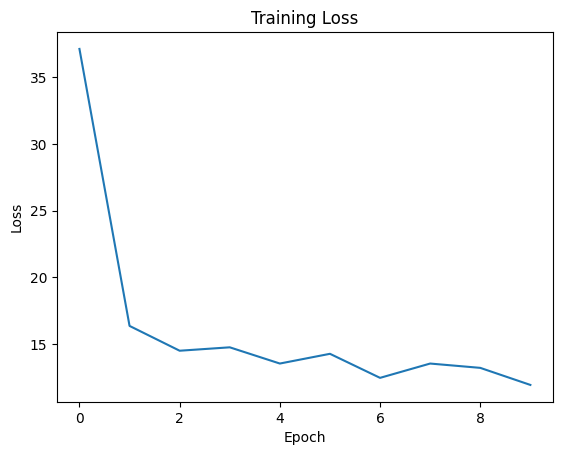

In [10]:
stats = trainer.get_stats()
stats.print_stats_summary()
stats.plot_train_loss()

## Node and Edge Prediction

In [8]:
def node_edge_loss_func(node_pred, node_label, edge_pred, edge_label):
    loss_func = torch.nn.L1Loss()
    node_loss = loss_func(node_pred, node_label)
    edge_loss = loss_func(edge_pred, edge_label)
    return node_loss + edge_loss

In [9]:
model_params = config['model_parameters']['NodeEdgeGNN']
model = NodeEdgeGNN(**model_params, **base_model_params)

num_epochs = 10
optimizer = torch.optim.Adam(model.parameters(), lr=lr_info['learning_rate'], weight_decay=lr_info['weight_decay'])
loss_func = node_edge_loss_func

trainer = DualRegressionTrainer(train_dataset=train_dataset, val_dataset=test_dataset, model=model,
                                loss_func=loss_func, optimizer=optimizer, num_epochs=num_epochs, device=device)
trainer.train()
trainer.validate()

Epoch [1/10], Training Loss: 30.5009
Epoch [2/10], Training Loss: 0.7499
Epoch [3/10], Training Loss: 0.6726
Epoch [4/10], Training Loss: 0.6738
Epoch [5/10], Training Loss: 0.6738
Epoch [6/10], Training Loss: 50324.3104
Epoch [7/10], Training Loss: 18.5831
Epoch [8/10], Training Loss: 27.6478
Epoch [9/10], Training Loss: 18.8160
Epoch [10/10], Training Loss: 16.4935


Final training Loss: 16.4935
Average training Loss: 5043.9122
Minimum training Loss: 0.6726
Maximum training Loss: 50324.3104
Total training time: 55.5277 seconds
Validation Loss: 16.1494
Inference time: 0.0089 seconds


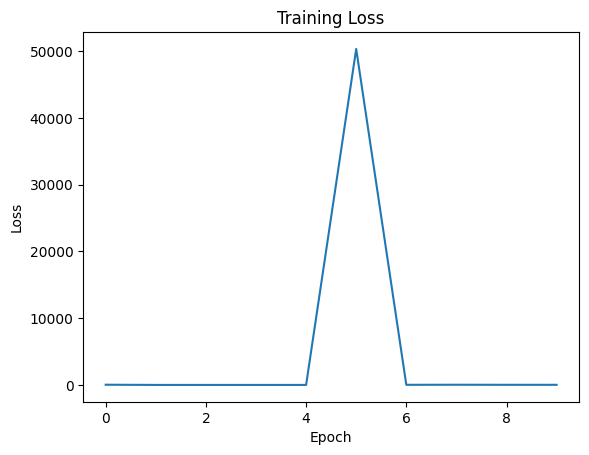

In [10]:
stats = trainer.get_stats()
stats.print_stats_summary()
stats.plot_train_loss()

In [11]:
# Test with just Node Prediction
model = NodeEdgeGNN(**model_params, **base_model_params)
optimizer = torch.optim.Adam(model.parameters(), lr=lr_info['learning_rate'], weight_decay=lr_info['weight_decay'])
loss_func = torch.nn.L1Loss()
trainer = DualRegressionTrainer(train_dataset=train_dataset, val_dataset=test_dataset, model=model,
                                loss_func=loss_func, optimizer=optimizer, num_epochs=num_epochs, device=device,
                                mode='node')
trainer.train()
trainer.validate()

Epoch [1/10], Training Loss: 32.9814
Epoch [2/10], Training Loss: 0.4615
Epoch [3/10], Training Loss: 0.4827
Epoch [4/10], Training Loss: 0.4691
Epoch [5/10], Training Loss: 0.5596
Epoch [6/10], Training Loss: 0.4685
Epoch [7/10], Training Loss: 0.5260
Epoch [8/10], Training Loss: 13865.3764
Epoch [9/10], Training Loss: 0.7634
Epoch [10/10], Training Loss: 0.7409


Final training Loss: 0.7409
Average training Loss: 1390.2829
Minimum training Loss: 0.4615
Maximum training Loss: 13865.3764
Total training time: 50.6878 seconds
Validation Loss: 0.2032
Inference time: 0.0068 seconds


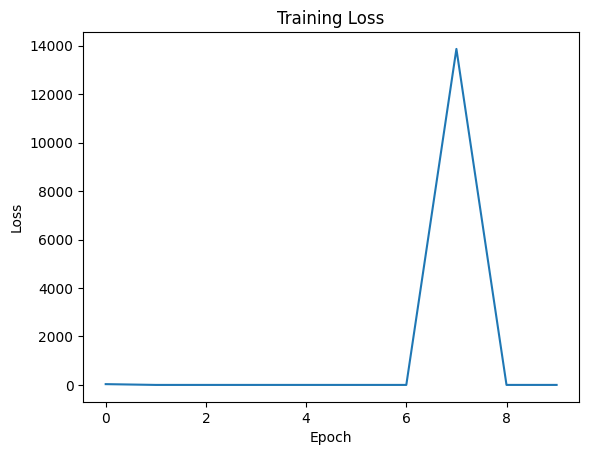

In [12]:
stats = trainer.get_stats()
stats.print_stats_summary()
stats.plot_train_loss()

## Edge Prediction Models

In [ ]:
edge_model_map = {
    'EdgeGNN': EdgeGNN,
}

In [ ]:
model_name = 'EdgeGNN' # Choose from the ff: EdgeGNN
model_params = config['model_parameters'][model_name]
model = edge_model_map[model_name](**model_params, **base_model_params)

num_epochs = 10
optimizer = torch.optim.Adam(model.parameters(), lr=lr_info['learning_rate'], weight_decay=lr_info['weight_decay'])
loss_func = torch.nn.L1Loss()

trainer = EdgeRegressionTrainer(train_dataset=train_dataset, val_dataset=test_dataset, model=model,
                                loss_func=loss_func, optimizer=optimizer, num_epochs=num_epochs, device=device)
trainer.train()
trainer.validate()

Epoch [1/10], Training Loss: 15.5595
Epoch [2/10], Training Loss: 0.1695
Epoch [3/10], Training Loss: 0.1604
Epoch [4/10], Training Loss: 0.1544
Epoch [5/10], Training Loss: 0.1537
Epoch [6/10], Training Loss: 0.1539
Epoch [7/10], Training Loss: 0.1540
Epoch [8/10], Training Loss: 0.1587
Epoch [9/10], Training Loss: 0.2097
Epoch [10/10], Training Loss: 0.1854


Final training Loss: 0.1854
Average training Loss: 1.7059
Minimum training Loss: 0.1537
Maximum training Loss: 15.5595
Total training time: 9.7774 seconds
Validation Loss: 0.1083
Inference time: 0.0011 seconds


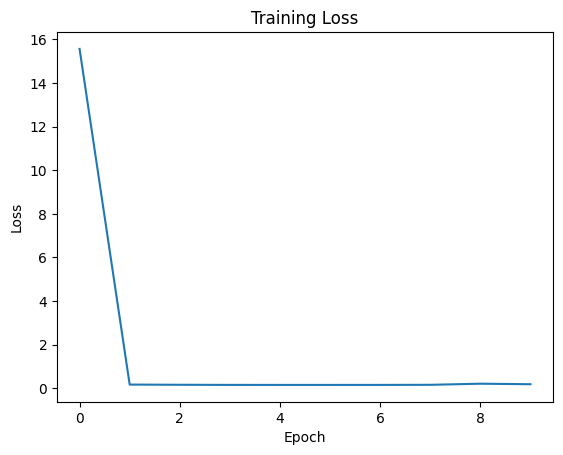

In [ ]:
stats = trainer.get_stats()
stats.print_stats_summary()
stats.plot_train_loss()

## Self-Supervised Learning Methods

In [ ]:
from tqdm import tqdm
from models.graph_mae2 import GraphMAE2
from utils.graph_mae2_utils import LinearRegression

In [ ]:
dataset, info = FloodingEventDataset(node_features=config['node_features'],
                    edge_features=config['edge_features'],
                    **config['dataset_parameters']).load()

print(len(dataset))
print(dataset[0])
print(type(dataset[0].x), dataset[0].x.shape)
print(type(dataset[0].edge_index), dataset[0].edge_index.shape)
print(type(dataset[0].edge_attr), dataset[0].edge_attr.shape)
print(type(dataset[0].y), dataset[0].y.shape)
print(info)

336
Data(x=[1268, 6], edge_index=[2, 5224], edge_attr=[5224, 8], y=[1268, 1], pos=[2, 1268])
<class 'torch.Tensor'> torch.Size([1268, 6])
<class 'torch.Tensor'> torch.Size([2, 5224])
<class 'torch.Tensor'> torch.Size([5224, 8])
<class 'torch.Tensor'> torch.Size([1268, 1])
{'num_static_node_features': 3, 'num_dynamic_node_features': 1, 'num_static_edge_features': 5, 'num_dynamic_edge_features': 1, 'previous_timesteps': 2}


In [ ]:
num_train = int(len(dataset) * 0.8) # 80% train, 20% test

train_dataset = dataset[:num_train]
# train_loader = DataLoader(train_dataset) # batch_size=32, shuffle=True

test_dataset = dataset[num_train:]
# test_loader = DataLoader(test_dataset) # batch_size=32, shuffle=True

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
base_model_params = {
    'static_node_features': info['num_static_node_features'],
    'dynamic_node_features': info['num_dynamic_node_features'],
    'static_edge_features': info['num_static_edge_features'],
    'dynamic_edge_features': info['num_dynamic_edge_features'],
    'previous_timesteps': info['previous_timesteps'],
    'device': device,
}
lr_info = config['training_parameters']
model_info = config['model_parameters']

In [ ]:
def pretrain(model, dataset, optimizer):
    start_time = time.time()

    max_epoch = 20
    epoch_iter = tqdm(range(max_epoch))
    model.to(device)
    for epoch in epoch_iter:
        model.train()
        running_loss = 0.0

        for graph in dataset:
            graph = graph.to(device)
            x = graph.x # Target
            target_nodes = torch.arange(x.shape[0], device=device, dtype=torch.long)

            optimizer.zero_grad()

            loss = model(graph, x, targets=target_nodes)
            running_loss += loss.item()

            loss.backward()
            optimizer.step()

        epoch_loss = running_loss / num_train
        epoch_iter.set_description(f"# Epoch {epoch}: train_loss: {epoch_loss:.4f}")

    end_time = time.time()
    print(f'Total pre-training time: {(end_time - start_time):4f} seconds')
    return model

def linear_probing(model, dataset, in_dim, out_dim, lr_f, weight_decay_f):
    start_time = time.time()

    decoder = LinearRegression(in_dim, out_dim).to(device)

    num_finetune_params = [p.numel() for p in decoder.parameters() if  p.requires_grad]
    print(f"num parameters for finetuning: {sum(num_finetune_params)}")

    loss_f = torch.nn.MSELoss()
    optimizer_f = torch.optim.Adam(decoder.parameters(), lr=lr_f, weight_decay=weight_decay_f)

    best_model = None
    max_epoch_f = 50
    epoch_iter_f = tqdm(range(max_epoch_f))
    model.eval()
    decoder.train()
    for epoch in epoch_iter_f:
        running_loss = 0.0

        for graph in dataset:
            optimizer_f.zero_grad()

            graph = graph.to(device)
            with torch.no_grad():
                x = model.embed(graph)
                x = x.to(device)
            label = graph.y

            out = decoder(x)
            loss = loss_f(out, label)

            loss.backward()
            optimizer_f.step()
            running_loss += loss.item()

        epoch_loss = running_loss / num_train
        epoch_iter_f.set_description(f"# Epoch {epoch}: train_loss: {epoch_loss:.4f}")

    end_time = time.time()
    print(f'Final loss: {epoch_loss:4f}')
    print(f'Total fine-tuning time: {(end_time - start_time):4f} seconds')

    return decoder

def test_ssl(model, ft_model, dataset, loss_func):
    start_time = time.time()
    model.eval()
    ft_model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for graph in dataset:
            graph = graph.to(device)
            x = model.embed(graph)
            labels = graph.y

            outputs = ft_model(x)

            loss = loss_func(outputs, labels)
            running_loss += loss.item()
    end_time = time.time()

    # Print validation statistics
    print(f'Validation Loss: {running_loss:.4f}')
    print(f'Inference time: {end_time - start_time} seconds')

In [ ]:
graphmae2_params = model_info['GRAPHMAE2']
in_dim = dataset[0].x.shape[1]
model = GraphMAE2(in_dim=in_dim, **graphmae2_params)
optimizer = torch.optim.Adam(model.parameters(), lr=lr_info['learning_rate'], weight_decay=lr_info['weight_decay'])

trained_model = pretrain(model, train_dataset, optimizer)

=== Use sce_loss and alpha_l=3 ===


# Epoch 19: train_loss: 0.0224: 100%|██████████| 20/20 [01:35<00:00,  4.77s/it]

Total pre-training time: 95.315137 seconds


In [ ]:
out_dim = dataset[0].y.shape[1]
hidden_dim = graphmae2_params['num_hidden'] // graphmae2_params['nhead']
ft_model = linear_probing(trained_model, train_dataset, hidden_dim, out_dim, 0.0008, lr_info['weight_decay'])

num parameters for finetuning: 2177


# Epoch 49: train_loss: 620.0525: 100%|██████████| 50/50 [00:56<00:00,  1.13s/it] 

Final loss: 620.052530
Total fine-tuning time: 56.627321 seconds


In [ ]:
loss_func = torch.nn.L1Loss()
test_ssl(trained_model, ft_model, test_dataset, loss_func)

Validation Loss: 32728.5642
Inference time: 0.2315971851348877 seconds


In [ ]:
from models.gine.pretrain_contextpred import main

model_file = 'models/gine/trained_model/gine_pretrain'
main(model_file)


cbow
num layer: 5 l1: 4 l2: 7
6
6
6
6
6
====epoch 1


Iteration:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([12894, 6])
torch.Size([12894, 1])


Iteration:   0%|          | 0/2 [00:20<?, ?it/s]


RuntimeError: running_mean should contain 1 elements not 6